In [ ]:
# Writer: Yoo Young Seok
# Date: 2023-05-07

Our main datasets to use in this project is tweet posts in Twitter. The link to download is here: https://www.kaggle.com/datasets/mazlumi/mbti-personality-type-twitter-dataset

In [ ]:
import pandas as pd

In [ ]:
# Specify folder location for this project (where your datasets located)

folder_loc = '/content/drive/MyDrive/Colab Notebooks/·Ñã·Öµ·Ü´·ÑÄ·Ö©·Üº·Ñå·Öµ·ÑÇ·Ö≥·Üº·Ñë·Ö≥·ÑÖ·Ö©·Ñå·Ö¶·Ü®·Ñê·Ö≥/TEAM/' 

In [ ]:
df = pd.read_csv(folder_loc + 'twitter_MBTI.csv')

In [ ]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7811 non-null   int64 
 1   text        7811 non-null   object
 2   label       7811 non-null   object
dtypes: int64(1), object(2)
memory usage: 183.2+ KB


In [ ]:
df.head()

Unnamed: 0                                               text label
0           0  @Pericles216 @HierBeforeTheAC @Sachinettiyil T...  intj
1           1  @Hispanthicckk Being you makes you look cute||...  intj
2           2  @Alshymi Les balles sont r√©elles et sont tir√©e...  intj
3           3  I'm like entp but idiotic|||Hey boy, do you wa...  intj
4           4  @kaeshurr1 Give it to @ZargarShanif ... He has...  intj

In [ ]:
df = df.drop('Unnamed: 0', axis= 1) # remove unncessary column which is the same as index
df['label'] = df['label'].str.upper() # MBMTI label to upper

In [ ]:
# we set ESTJ the base MBTI

# transform label to each E(E = 1, I = 0), S(S = 1, N = 0), T(T = 1, F = 0), J(J = 1, P = 0).
df['E'] = df['label'].str[0].apply(lambda x: 1 if x == 'E' else 0)
df['S'] = df['label'].str[1].apply(lambda x: 1 if x == 'S' else 0)
df['T'] = df['label'].str[2].apply(lambda x: 1 if x == 'T' else 0)
df['J'] = df['label'].str[3].apply(lambda x: 1 if x == 'J' else 0)

df.head()

text label  E  S  T  J
0  @Pericles216 @HierBeforeTheAC @Sachinettiyil T...  INTJ  0  0  1  1
1  @Hispanthicckk Being you makes you look cute||...  INTJ  0  0  1  1
2  @Alshymi Les balles sont r√©elles et sont tir√©e...  INTJ  0  0  1  1
3  I'm like entp but idiotic|||Hey boy, do you wa...  INTJ  0  0  1  1
4  @kaeshurr1 Give it to @ZargarShanif ... He has...  INTJ  0  0  1  1

## Data Visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

The number of exmaples for each MBTI type

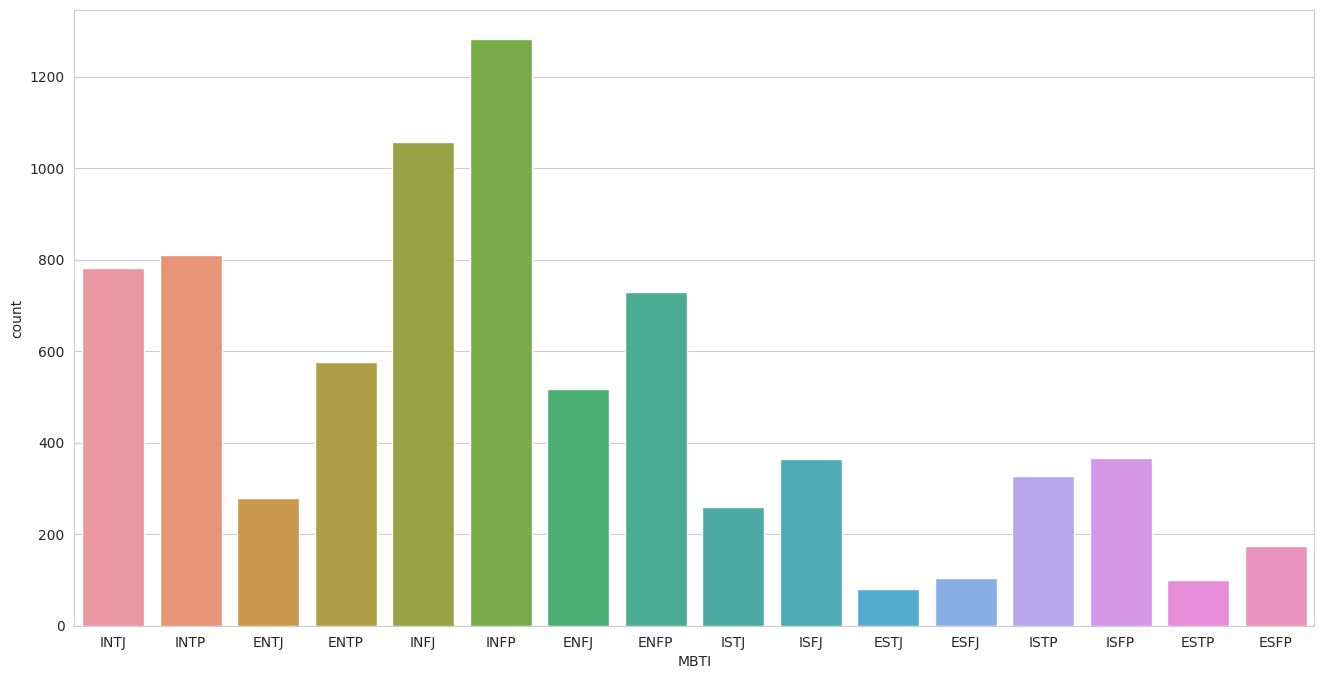

In [ ]:
sns.set_style('whitegrid')

plt.figure(figsize=(16, 8))
ax = sns.countplot(data=df, x='label')
ax.set_xlabel('MBTI')

plt.show()

The number of examples of each 4 types of MBTI (E vs I, S vs N, T vs F, J vs P)

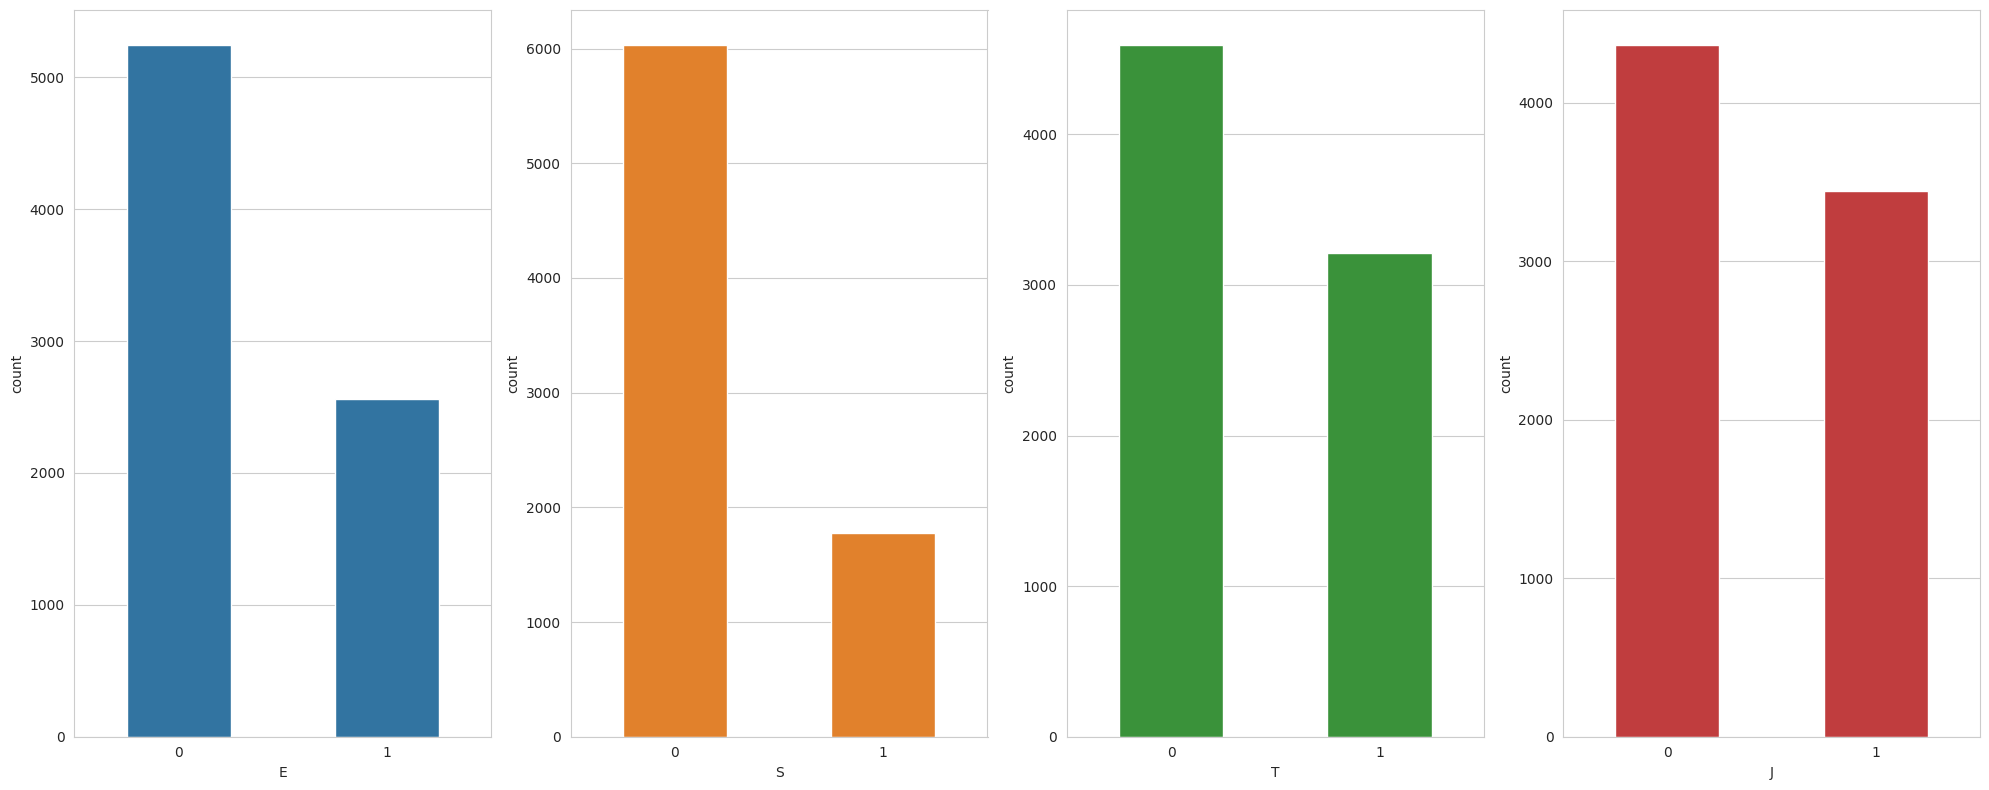

In [ ]:
base = 'ESTJ'

plt.figure(figsize=(20, 8))
colors = plt.rcParams["axes.prop_cycle"]()

for i in range(4):
  plt.subplot(1, 4, i+1)
  c = next(colors)['color']
  sns.countplot(data=df, x=base[i], width=0.5, color=c)

plt.tight_layout()
plt.show()

From these distributions, one we have to do is fill the dificient MBTI datasets

1. I > E
2. N > S
3. F > T
4. P > J

The distribution of the length of text data of each users

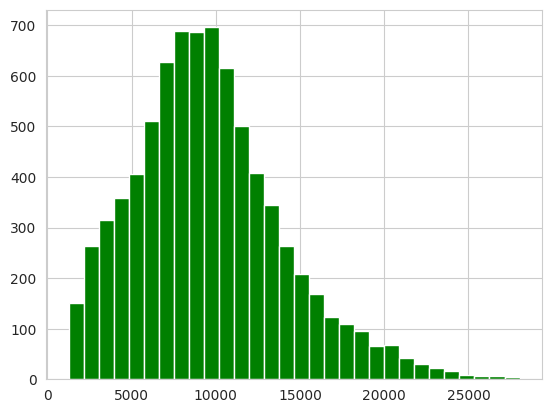

In [ ]:
text_length = df['text'].apply(len)

plt.hist(x=text_length, bins=30, color='green')
plt.show()

### Observation

Let's look a one of text examples then observe the things that need to be preprocessed

In [ ]:
df.loc[700]['text'] # show one of the text examples

'@PFF_Sam Also dog. Allergies...\n\nKids are a must but are in the same boat if we are being honest.|||@elonmusk @BillyM2k It\'s the cross us health nuts must bare.|||@PFF @PFF_Eric Some are HCs.... other should have Mike\'s Job.|||@fugl3kvidd3r @RichardDawkins Just means he percentage and article lacks context.\n\nI am not one who understands how‚Ä¶ https://t.co/KwYIpSf0vQ|||@RichardDawkins which god?|||@samrhall @RexChapman But when you are tired of reality and want to escape to a fantasy world far far away...|||Watching all these @Mike_Schmitz videos, it is crazy how well spoken and in tune with plays/IQ these player are com‚Ä¶ https://t.co/SEaUfi4zsB|||@JaMorant The @Timberwolves passed on him TWICE then traded Wiggins &amp; Kuminga to get rid of Russell and clear the s‚Ä¶ https://t.co/5ivsAsOQil|||@ArtValley818_ @DMRHerbs People are so shitty|||@Zaknoble Is this best player or accomplishments or best player per era?|||Celtics had a hell of a season and should be proud.\n\nThe offs

## Text Data Preprocessing

### 1. Removing separations of each entries

The model we are going to use is BERT. In BERT paper, sentence is not a sentence we generally thought. BERT says that sentence can be *paragraph*, contiguous text.

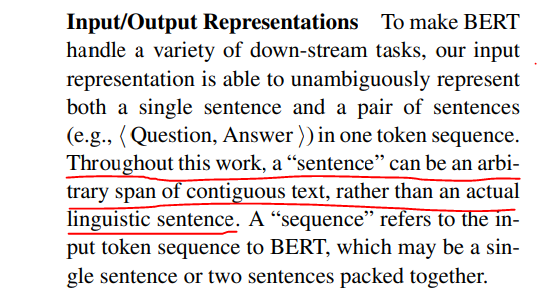

In these text datasets, each tweets are separated by '|||', 3 pipe characters. But for above reason, these does not help for BERT, even have possibility to make BERT understand these meaningless characters, also memory-ineffective. So, we remove these characters to just ' ' (space).

In [ ]:
df['text'] = df['text'].str.replace('|||', ' ', regex=False)

### 2. Link to Text

As seen above, you may find lots of URL link texts such as https://t.co/KwYIpSf0vQ. But this rough texts are not helpful for text classificatoin. To transform these links to meaningful words, we decide to replace them with title of the pages.

!!!

However, There is a problem when I use normal HTTP requests to get HTTP response for html. It's that some tags and contents are missing! We tried to find reasons and notice that some contents are created dynamically with JS engine in browser. And the solution for this we figured out is to use Selenium WebDriver. It is a popular open-source automation for web browser. After an effort to apply it to Colab environment, we did it. The browser we chose is Firefox because Chrome still has many issues when applying to colab. (It may be the version issue because recently Colab OS is upgraded to 18.04LTS to 20.04LTS) 

However, Selenium is much slower than normal requests!!!

In [ ]:
!apt install firefox xvfb 
!pip install pyvirtualdisplay selenium webdriver_manager  

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libdbus-glib-1-2 libdbusmenu-glib4 libdbusmenu-gtk3-4 libfontenc1 libxfont2
  libxkbfile1 libxtst6 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xul-ext-ubufox
Suggested packages:
  fonts-lyx
The following NEW packages will be installed:
  firefox libdbus-glib-1-2 libdbusmenu-glib4 libdbusmenu-gtk3-4 libfontenc1
  libxfont2 libxkbfile1 libxtst6 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xul-ext-ubufox xvfb
0 upgraded, 15 newly installed, 0 to remove and 24 not upgraded.
Need to get 68.5 MB of archives.
After this operation, 256 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libdbus-glib-1-2 amd64 0.110-5fakssync1 [59.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libxtst6 amd64 2:1.2.3-1 [12.8 kB]
Get:3 http://archiv

In [ ]:
import re
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager

regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

options = webdriver.FirefoxOptions()
options.add_argument("--no-sandbox")
options.add_argument("--headless")

But, there is a problem that the contents of the title are dynamically converted several times. What we want to use is final loaded title which is meaningful. So, We implemented to wait 3 seconds. After many experiments of calcualating amount of time, result is that in colab environment, 3 seconds are enough for average. 3 seconds more are too late.(We just wait for explicit time because there is no options to wait for dynamic changes.) Also, if there is another url in title, we delete it for simplicity by removeURL function we implemented.

In [ ]:
import time 

TIME_LIMIT = 3 # the time to wait for a page loading

In [ ]:
def removeURL(str):
  obj_iter = re.finditer(regex, str)

  for obj in obj_iter:
    url = obj.group()

    str = str.replace(url, '')
  
  return str


def replaceURLwithTitle(str):
  obj_iter = re.finditer(regex, str)
  driver = webdriver.Firefox(options=options, service=Service(GeckoDriverManager().install()))

  for obj in obj_iter:
    url = obj.group()
    driver.get(url)
    time.sleep(TIME_LIMIT)

    title = driver.title
    title = removeURL(title)

    print(url + ' -> ' + title) # for checking
    str = str.replace(url, title)
  
  driver.quit()
  return str

In [ ]:
replaceURLwithTitle(df.loc[700, 'text'])

[WDM] - Downloading: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2.93M/2.93M [00:00<00:00, 38.0MB/s]


https://t.co/KwYIpSf0vQ -> Phil on Twitter: "@fugl3kvidd3r @RichardDawkins Just means he percentage and article lacks context. I am not one who understands how people still believe in any religion in 2022 but if somehow this matters, I would argue the religio-political side would matter if Islamic vs Christian." / Twitter
https://t.co/SEaUfi4zsB -> Phil on Twitter: "Watching all these @Mike_Schmitz videos, it is crazy how well spoken and in tune with plays/IQ these player are compared to late 90's/2000's. These feel like grown men speaking." / Twitter
https://t.co/5ivsAsOQil -> Phil on Twitter: "@JaMorant The @Timberwolves passed on him TWICE then traded Wiggins &amp; Kuminga to get rid of Russell and clear the spot for Pool. Essentially giving them their best 2 players in the finals To the Wolves Management... " / Twitter
https://t.co/8d5TmYAsZ9 -> Phil on Twitter: "Celtics had a hell of a season and should be proud. The offseason will be all about how to get guys who can settle down 

'@PFF_Sam Also dog. Allergies...\n\nKids are a must but are in the same boat if we are being honest. @elonmusk @BillyM2k It\'s the cross us health nuts must bare. @PFF @PFF_Eric Some are HCs.... other should have Mike\'s Job. @fugl3kvidd3r @RichardDawkins Just means he percentage and article lacks context.\n\nI am not one who understands how‚Ä¶ Phil on Twitter: "@fugl3kvidd3r @RichardDawkins Just means he percentage and article lacks context. I am not one who understands how people still believe in any religion in 2022 but if somehow this matters, I would argue the religio-political side would matter if Islamic vs Christian." / Twitter @RichardDawkins which god? @samrhall @RexChapman But when you are tired of reality and want to escape to a fantasy world far far away... Watching all these @Mike_Schmitz videos, it is crazy how well spoken and in tune with plays/IQ these player are com‚Ä¶ Phil on Twitter: "Watching all these @Mike_Schmitz videos, it is crazy how well spoken and in tune w

### OMG!!!!

This way can generate meaningful text from ulr as seen above. But the serious probelm is that even one running above spent more than 5 hours!!! Our dataset has about 7811 examples. So It gonna be about more than 30 days for applying to whole exampels. OK so let's go back to previous approches. It uses mechanize packages for getting response to URL.

In [ ]:
!pip install mechanize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 110.3/110.3 kB 3.2 MB/s eta 0:00:00


In [ ]:
from mechanize import Browser

In [ ]:
def replaceURLwithTitle(str):
  obj_iter = re.finditer(regex, str)
  br = Browser()
  br.set_handle_robots(False)

  for obj in obj_iter:
    url = obj.group()
    br.open(url)

    title = br.title()
    title = removeURL(title)

    print(url + ' -> ' + title) # for checking
    str = str.replace(url, title)
  
  return str

In [ ]:
replaceURLwithTitle(df.loc[700, 'text'])

https://t.co/KwYIpSf0vQ -> 
https://t.co/SEaUfi4zsB -> 
https://t.co/5ivsAsOQil -> 
https://t.co/8d5TmYAsZ9 -> 
https://t.co/hQG6MA3Sl3 -> 
https://t.co/65tfJgSbqq -> 
https://t.co/y1iJSNba2X -> 
https://t.co/JQFQcGJTwp -> Big Board Check-In - The Chase Down: A Cleveland Cavaliers Pod | Podcast on Spotify
https://t.co/opoPaKXeCS -> 
https://t.co/dAkqZMYgAU -> 
https://t.co/zkl35xlzmW -> 
https://t.co/jx9VRuOTDX -> 
https://t.co/TbzyPdd5mA -> 
https://t.co/DEOVMAkoA6 -> 
https://t.co/PwWKJ1qdFp -> 
https://t.co/NrApxLJgVo -> 
https://t.co/MvUz0b2vUH -> 
https://t.co/tPbHrqLuPh -> 
https://t.co/Z3JJuL0ivG -> 
https://t.co/ZcMOccmVhw -> React - YouTube
https://t.co/8M87hDloc6 -> 
https://t.co/2ROu0HEEwu -> 
https://t.co/VfNPSLSrt6 -> 
https://t.co/BBkgE32pR1 -> 
https://t.co/YvNGuon912 -> 
https://t.co/AhHTyYDFWr -> 
https://t.co/Ve1aZwnqBV -> 
https://t.co/eDIXMKHS37 -> 
https://t.co/7XcVIFZ8Nq -> 
https://t.co/pIiS9vNjKc -> 
https://t.co/m3QoNOYtDV -> 
https://t.co/2l0xlvRqEC -> 
https:

'@PFF_Sam Also dog. Allergies...\n\nKids are a must but are in the same boat if we are being honest. @elonmusk @BillyM2k It\'s the cross us health nuts must bare. @PFF @PFF_Eric Some are HCs.... other should have Mike\'s Job. @fugl3kvidd3r @RichardDawkins Just means he percentage and article lacks context.\n\nI am not one who understands how‚Ä¶  @RichardDawkins which god? @samrhall @RexChapman But when you are tired of reality and want to escape to a fantasy world far far away... Watching all these @Mike_Schmitz videos, it is crazy how well spoken and in tune with plays/IQ these player are com‚Ä¶  @JaMorant The @Timberwolves passed on him TWICE then traded Wiggins &amp; Kuminga to get rid of Russell and clear the s‚Ä¶  @ArtValley818_ @DMRHerbs People are so shitty @Zaknoble Is this best player or accomplishments or best player per era? Celtics had a hell of a season and should be proud.\n\nThe offseason will be all about how to get guys who can settle‚Ä¶  @moraivan I was just thinking 

As I mentioned first in this section, the results are really poor with twitter URL. But the biggest problem is that this approach also spend lots of time. The example spends 20 seconds. So It gonna be about 2 days for applying to whole exampels. This is not effective compared to outcomes.

**We hit the wall of replace URL with title. In conclusion, we just had to just remove all URLs using removeURL function implemented before...**

In [ ]:
df['text'] = df['text'].apply(removeURL)

### NOTICE 

But..you know...if we are going to use another datasets other than tweets, this may be helpful!!! Even if it spends much time, we leave this function and plan to utilize it to other datasets and prioritize efficiency.

### 3. Removing @ (mention symbol) & escape characters(\n,...)

In tweets, there are so many @, mention symbols. But this symbol is not helpful for text classification. But username after @ can be helpful because it means indicating and sometimes it can be a subject word itself. Also escape characters such as '\n' does not help models understand meaning of sentences. So, we also remove them

In [ ]:
df['text'] = df['text'].str.replace('@','') # Remove @

In [ ]:
# Remove escape characters
escapes = ''.join([chr(char) for char in range(1, 32)])
translator = str.maketrans('', '', escapes)
df['text'] = df['text'].str.translate(translator)

### 4. Emoji to Text

A pre-trained BERT  will only have reserved code points for them if they were in the data that was used to create the WordPiece tokenizer. But the WordPiece vocab does not mention emoji. So what we have to do is convert emoji to meaningful text

In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from emoji import demojize

In [ ]:
# Here is the example

temp = 'I love AI!üòÅ'
demojize(temp)

'I love AI!:beaming_face_with_smiling_eyes:'

In [ ]:
df['text'] = df['text'].apply(demojize)

### 5. Replace apostrophes with words

The last we could observe is that there are many appostrophes such as 's. So we replace them with words for more convenience of learning.

In [ ]:
df['text'] = df['text'].str.replace(r'n\'t', ' not', regex=False)
df['text'] = df['text'].str.replace(r'\'s', ' is', regex=False)
df['text'] = df['text'].str.replace(r'\'m', ' am', regex=False)
df['text'] = df['text'].str.replace(r'\'re', ' are', regex=False)
df['text'] = df['text'].str.replace(r'\'ve', ' have', regex=False)
df['text'] = df['text'].str.replace(r'\'ll', ' will', regex=False)
df['text'] = df['text'].str.replace(r'\'d', ' would', regex=False)

In [ ]:
df.to_csv(folder_loc + 'df_preprocessed.csv') # save the fully processed data

In [ ]:
df = pd.read_csv(folder_loc + 'df_preprocessed.csv')

## Run the baseline model (TfidfVectorizer + Logistic Regression Model)



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

TF-IDF Vectorizer is a measure of originality of a word by comparing the number of times a word appears in document with the number of documents the word appears in. TF-IDF = TF(t, d) x IDF(t), where, TF(t, d) = Number of times term 't' appears in a document 'd'. IDF(t) = Inverse document frequency of the term t.

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Totally normal TfidfVectorizer, all set to default except max_features
# It's about 65000 features with meaningless words so we had to limit them to 1000
# Also Default token pattern includes numbers which are less important features
# So we set pattern to be all words without numbers
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, token_pattern=r'(?u)\b[^\d\W]\w+\b')

X_train = vectorizer.fit_transform(train_data['text'])
X_test = vectorizer.transform(test_data['text'])
Y_train = train_data[['E', 'S', 'T', 'J']]
Y_test = test_data[['E', 'S', 'T', 'J']]

In [ ]:
# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame from the feature names and their corresponding TF-IDF scores
tfidf_scores = pd.DataFrame(X_train.toarray(), columns=feature_names)

# Group the data by label and calculate the mean of each feature for each label
mean_tfidf = tfidf_scores.groupby(train_data['label']).mean()

# Check the Results
mean_tfidf.head()

able  absolutely       abt       acc   account       act    active  \
label                                                                           
ENFJ   0.010466    0.009527  0.011705  0.006693  0.013164  0.004743  0.005661   
ENFP   0.007810    0.010098  0.010283  0.009654  0.008340  0.003794  0.003605   
ENTJ   0.007978    0.008373  0.022205  0.008038  0.008640  0.007159  0.005718   
ENTP   0.008442    0.008030  0.012704  0.007843  0.007001  0.006024  0.003518   
ESFJ   0.007170    0.007751  0.005746  0.004537  0.010460  0.002005  0.004101   

         actual  actually       add  ...       yep       yes  yesterday  \
label                                ...                                  
ENFJ   0.004943  0.021834  0.007130  ...  0.005885  0.029897   0.009074   
ENFP   0.005916  0.021957  0.006693  ...  0.003259  0.031875   0.007177   
ENTJ   0.004482  0.022567  0.006424  ...  0.008856  0.028987   0.007629   
ENTP   0.005917  0.023353  0.009591  ...  0.005656  0.036807   0.007914   
ESFJ   0.005681  0.016203  0.009116  ...  0.008088  0.033054   0.004702   

             yo    yoongi     young     youre   youtube      yung       yup  
label                                                                        
ENFJ   0.008108  0.003728  0.008862  0.005781  0.010188  0.004411  0.003964  
ENFP   0.007193  0.004306  0.006820  0.006632  0.010223  0.003894  0.005287  
ENTJ   0.007477  0.000000  0.005492  0.004379  0.018567  0.006191  0.005085  
ENTP   0.006412  0.002918  0.005023  0.006423  0.004254  0.007708  0.004452  
ESFJ   0.004456  0.001250  0.008728  0.006861  0.004953  0.010970  0.001282  

[5 rows x 1000 columns]

**Then, Let's look up the TOP 10 important features of each MBTI!!!**

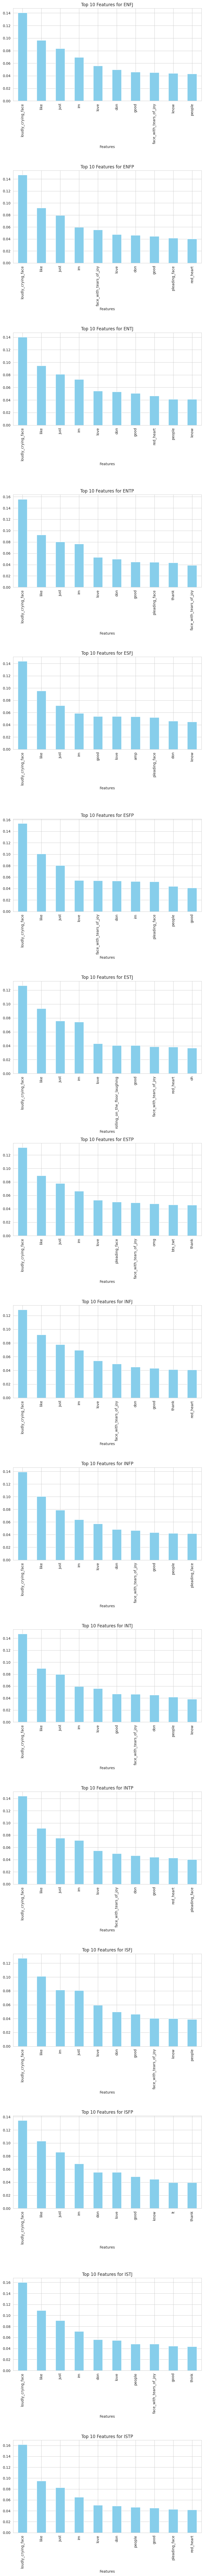

In [ ]:
plt.figure(figsize=(8, 100))

for i, (label, row) in enumerate(mean_tfidf.iterrows()):
  plt.subplot(16, 1, i+1)
  row.nlargest(10).T.plot(kind='bar', color='skyblue')
  plt.title('Top 10 Features for {}'.format(label))
  plt.xlabel('Features')

plt.tight_layout()
plt.show()

**Finally, Let's classify using Linear Regression!!!**

In [ ]:
def classify_logistic(x_train, x_test, y_train, y_test):
  model = LogisticRegression(solver='liblinear', C=4, random_state=11)

  model.fit(x_train, y_train)

  train_pred = model.predict(x_train)
  test_pred = model.predict(x_test)

  train_prob = model.predict_proba(x_train)
  test_prob = model.predict_proba(x_test)

  train_loss = log_loss(y_train, train_prob, eps=1e-15)
  test_loss = log_loss(y_test, test_prob, eps=1e-15)

  train_acc = accuracy_score(y_train, train_pred)
  test_acc = accuracy_score(y_test, test_pred)

  return test_pred, test_prob, train_loss, test_loss, train_acc, test_acc

**E - Result**

In [ ]:
E_test_pred, E_test_prob, E_train_loss, E_test_loss, E_train_acc, E_test_acc = classify_logistic(
    X_train, X_test, Y_train['E'], Y_test['E'])

print('Log loss on training set:',E_train_loss)
print('Accuracy on training set:', E_test_loss)
print('Log loss on test set:', E_test_loss)
print('Accuracy on test set:', E_test_acc)

Log loss on training set: 0.5204484308306568
Accuracy on training set: 0.6569483234093896
Log loss on test set: 0.6569483234093896
Accuracy on test set: 0.6373720136518771


**S - Result**

In [ ]:
S_test_pred, S_test_prob, S_train_loss, S_test_loss, S_train_acc, S_test_acc = classify_logistic(
    X_train, X_test, Y_train['S'], Y_test['S'])

print('Log loss on training set:',S_train_loss)
print('Accuracy on training set:', S_test_loss)
print('Log loss on test set:', S_test_loss)
print('Accuracy on test set:', S_test_acc)

Log loss on training set: 0.4324439799663822
Accuracy on training set: 0.5389430173816806
Log loss on test set: 0.5389430173816806
Accuracy on test set: 0.761518771331058


**T - Result**

In [ ]:
T_test_pred, T_test_prob, T_train_loss, T_test_loss, T_train_acc, T_test_acc = classify_logistic(
    X_train, X_test, Y_train['T'], Y_test['T'])

print('Log loss on training set:',T_train_loss)
print('Accuracy on training set:', T_test_loss)
print('Log loss on test set:', T_test_loss)
print('Accuracy on test set:', T_test_acc)

Log loss on training set: 0.5377519614921477
Accuracy on training set: 0.6742101730710616
Log loss on test set: 0.6742101730710616
Accuracy on test set: 0.6053754266211604


**J - Result**

In [ ]:
J_test_pred, J_test_prob, J_train_loss, J_test_loss, J_train_acc, J_test_acc = classify_logistic(
    X_train, X_test, Y_train['J'], Y_test['J'])

print('Log loss on training set:',J_train_loss)
print('Accuracy on training set:', J_test_loss)
print('Log loss on test set:', J_test_loss)
print('Accuracy on test set:', J_test_acc)

Log loss on training set: 0.553627073574468
Accuracy on training set: 0.6686302612242798
Log loss on test set: 0.6686302612242798
Accuracy on test set: 0.6228668941979523


**Total Result**

With combinations of each type of results, we can make whole MBTI predictions. Using these predictions, we calcuate the final result of MBTI predictions.

In [ ]:
import numpy as np

In [ ]:
Test_pred = np.column_stack((E_test_pred, S_test_pred, T_test_pred, J_test_pred))
print('Accuracy on test set:', accuracy_score(Y_test, Test_pred))

Accuracy on test set: 0.19197952218430034
